In [1]:
# cats_and_dogs classification model with CNN
# train : 2000 images [cat(1000) + dog(1000)]  , size는 다름
# validation : 1000 images [cat(500) + dog(500)] , size는 다름

In [2]:
import tensorflow as tf
import urllib
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

In [3]:
# Colab용 : Linux/GPU사용 
# !wget --no-check-certificate \
#   https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
#   -O /tmp/cats_and_dogs_filtered.zip

In [4]:
# ! mkdir tmp
# ! ls

In [5]:
# cats_and_dogs 데이터셋 다운로드 , Windows용  ,현재 경로 아래에 tmp/ 디렉토리가 있어야 가능
_TRAIN_URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
urllib.request.urlretrieve(_TRAIN_URL, 'tmp/cats_and_dogs_filtered.zip')

('tmp/cats_and_dogs_filtered.zip', <http.client.HTTPMessage at 0x7feb0e740410>)

In [6]:
# 압축 해제
local_zip = 'tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('tmp/')
zip_ref.close()

In [7]:
# 이미지 데이터 경로 설정
import os

base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

print('total training cat images :', len(os.listdir(train_cats_dir ) ))
print('total training dog images :', len(os.listdir(train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir(validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir(validation_dogs_dir ) ))

['cat.721.jpg', 'cat.606.jpg', 'cat.76.jpg', 'cat.290.jpg', 'cat.450.jpg', 'cat.738.jpg', 'cat.21.jpg', 'cat.117.jpg', 'cat.737.jpg', 'cat.182.jpg']
['dog.785.jpg', 'dog.838.jpg', 'dog.609.jpg', 'dog.283.jpg', 'dog.833.jpg', 'dog.974.jpg', 'dog.371.jpg', 'dog.477.jpg', 'dog.831.jpg', 'dog.285.jpg']
total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


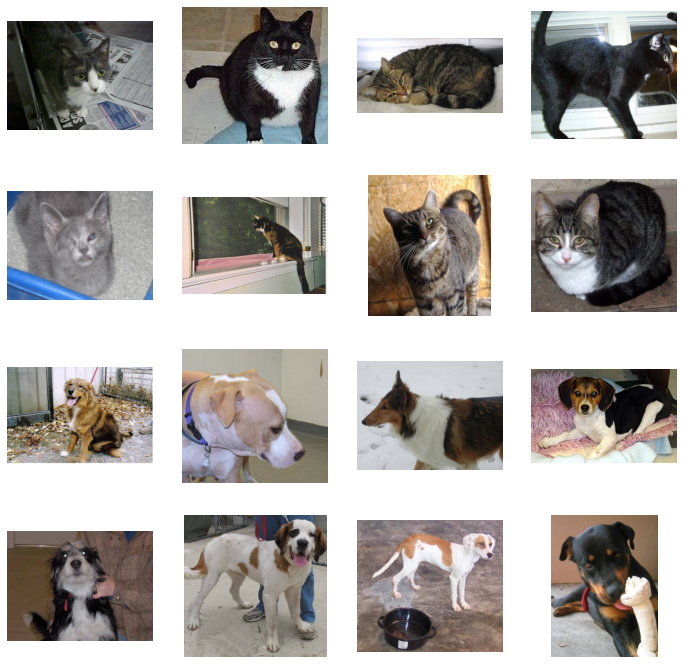

In [8]:
# 데이터 시각화
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images ,시작 인덱스

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*3, nrows*3)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

### CNN Model 구현

In [9]:
# 모델 구현
model = tf.keras.Sequential([
    # input image size : 150*150
    tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(150,150,3)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')    
])

model.compile(optimizer=RMSprop(learning_rate=0.001),
             loss='binary_crossentropy',
             metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

### 데이터 전처리 : 이미지 증강(Image Augmentation)

In [10]:
# rescale : 1.0/255. , batch_size:20 ,epochs=15  ,target_size : (150,150)

train_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(
                  train_dir,
                  target_size=(150,150),
                  batch_size=20,
                  class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
                  validation_dir,
                  target_size=(150,150),
                  batch_size=20,
                  class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
# 학습  : CPU 약 10분 소요
history = model.fit(train_generator,
                   steps_per_epoch=100,
                   epochs=15,
                   validation_data=validation_generator,
                   validation_steps=50,
                   verbose=1)

Epoch 1/15
100/100 [==============================] - 19s 88ms/step - loss: 0.7566 - accuracy: 0.5610 - val_loss: 0.6300 - val_accuracy: 0.6780
Epoch 2/15
100/100 [==============================] - 9s 87ms/step - loss: 0.6319 - accuracy: 0.6690 - val_loss: 0.5861 - val_accuracy: 0.6940
Epoch 3/15
100/100 [==============================] - 9s 86ms/step - loss: 0.5391 - accuracy: 0.7330 - val_loss: 0.5983 - val_accuracy: 0.6850
Epoch 4/15
100/100 [==============================] - 14s 141ms/step - loss: 0.4461 - accuracy: 0.8060 - val_loss: 1.1559 - val_accuracy: 0.5630
Epoch 5/15
100/100 [==============================] - 9s 85ms/step - loss: 0.3621 - accuracy: 0.8460 - val_loss: 0.6138 - val_accuracy: 0.7260
Epoch 6/15
100/100 [==============================] - 9s 87ms/step - loss: 0.2869 - accuracy: 0.8765 - val_loss: 0.7330 - val_accuracy: 0.6940
Epoch 7/15
100/100 [==============================] - 9s 87ms/step - loss: 0.1964 - accuracy: 0.9275 - val_loss: 0.7418 - val_accuracy: 0.7

### 학습 결과 시각화

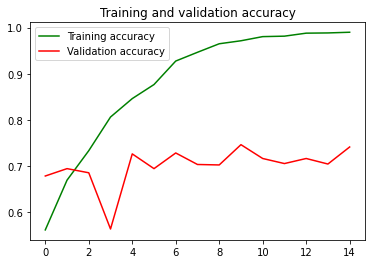

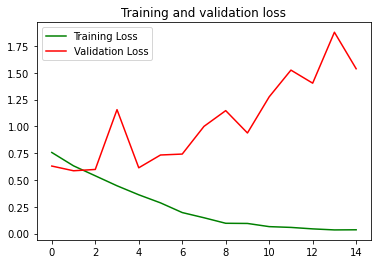

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 이미지 분류 예측 

In [14]:
# import numpy as np
# from tensorflow.keras.preprocessing import image
# def image_predict(file_name):
#     path = 'cats_and_dogs예측용이미지/' + file_name
#     img = image.load_img(path, target_size=(150, 150))
#     x = image.img_to_array(img)   # 2차원 ndarray로 변환
#     x = np.expand_dims(x, axis=0) # 3차원으로 변환
#     images = np.vstack([x])       # 4차원으로 변환
#     classes = model.predict(images, batch_size=10)
#     # print(classes[0],end=' ')
#     if classes[0] == 1.0:
#         print(file_name ,': dogs')
#     else:
#         print(file_name ,': cats')


# image_predict('cat_01.jpg')        
# image_predict('cat_02.jpg')        
# image_predict('cat_03.jpg')        
# image_predict('cat_04.jpg')        
# image_predict('cat_05.jpg') 

# image_predict('dog_01.jpg')        
# image_predict('dog_02.jpg')        
# image_predict('dog_03.jpg')        
# image_predict('dog_04.jpg')        
# image_predict('dog_05.jpg')        

# image_predict('cat_dog_01.jpg')   
# image_predict('cat_dog_02.jpg')   
# image_predict('cat_dog_03.jpg')   
# image_predict('cat_dog_04.jpg')   
# image_predict('cat_dog_05.jpg')   

### 모델 개선  : 정확도 향상

In [15]:
# 모델 구현
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')    
])

model.compile(optimizer=RMSprop(learning_rate=1e-4), # 0.001 --> 0.0001
             loss='binary_crossentropy',
             metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 128)     

### 이미지 증강 구현

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(
                  train_dir,
                  target_size=(150,150),
                  batch_size=20,
                  class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
                  validation_dir,
                  target_size=(150,150),
                  batch_size=20,
                  class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [17]:
# 학습  : Colab 약 30분 소요
history = model.fit(train_generator,
                   steps_per_epoch=100,
                   epochs=100,
                   validation_data=validation_generator,
                   validation_steps=50,
                   verbose=1)

Epoch 1/100
100/100 [==============================] - 20s 190ms/step - loss: 0.6929 - accuracy: 0.5125 - val_loss: 0.6880 - val_accuracy: 0.5280
Epoch 2/100
100/100 [==============================] - 18s 176ms/step - loss: 0.6884 - accuracy: 0.5345 - val_loss: 0.6646 - val_accuracy: 0.5960
Epoch 3/100
100/100 [==============================] - 18s 180ms/step - loss: 0.6729 - accuracy: 0.5670 - val_loss: 0.6427 - val_accuracy: 0.6310
Epoch 4/100
100/100 [==============================] - 17s 171ms/step - loss: 0.6558 - accuracy: 0.6085 - val_loss: 0.6228 - val_accuracy: 0.6390
Epoch 5/100
100/100 [==============================] - 17s 171ms/step - loss: 0.6437 - accuracy: 0.6220 - val_loss: 0.6089 - val_accuracy: 0.6670
Epoch 6/100
100/100 [==============================] - 18s 179ms/step - loss: 0.6231 - accuracy: 0.6315 - val_loss: 1.0433 - val_accuracy: 0.5090
Epoch 7/100
100/100 [==============================] - 17s 172ms/step - loss: 0.6247 - accuracy: 0.6365 - val_loss: 0.7961 -

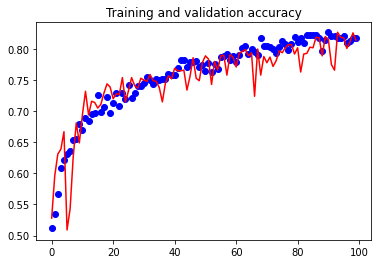

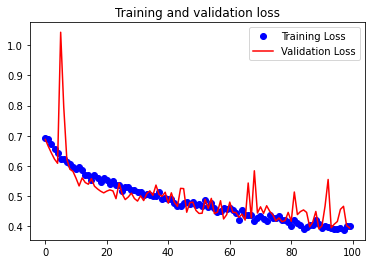

In [18]:
# 시각화
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()